El metodo que se utiliza es collaborative filtering
,el cual, intenta encontrar usuarios similares
para ofrecer un items(peliculas, libros, musica,etc)
 bien valorado para ese perfil. Lo primordial 
de esta tecnica es el algoritmo de distancia que se utiliza,
 ya que, depende de este los buenos resultados.
Una manera de calcular estas distancia es 'distancia por coseno'.
 Lo calcula creando un espacio vectorial
con n dimensiones correspondiente al numero de items, luego calcula
 el angulo entre cada vector. 
A menor distancia, mayor similitud.
 

In [15]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [3]:
df = pd.read_csv("u.data.csv", sep="\t", header=None)
df

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [4]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]
df

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


(array([ 6110.,     0., 11370.,     0., 27145.,     0., 34174., 21201.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 8 artists>)

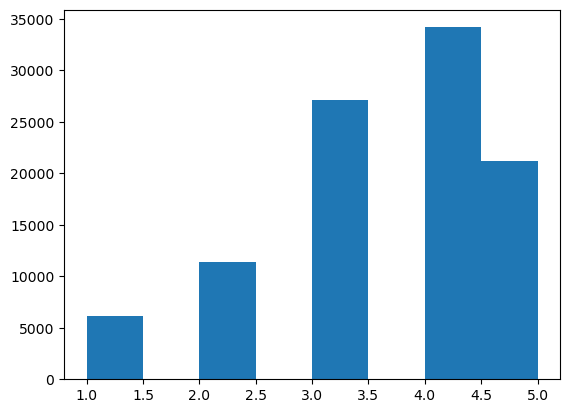

In [5]:
plt.hist(df.Rating,bins=8)

In [6]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

Text(0.5, 0, 'Valoraciones')

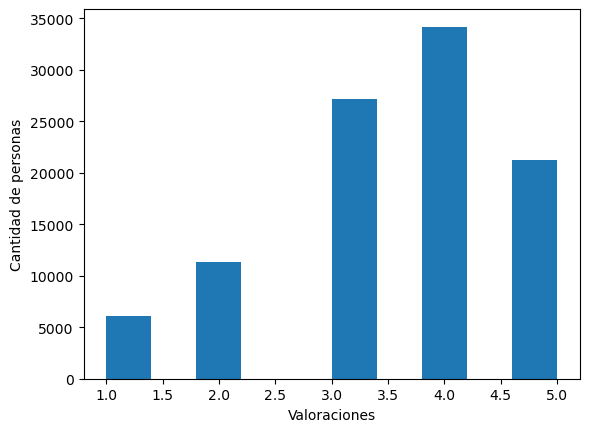

In [7]:
# nos da una idea de como se distribuyen lsa valoraciones
# de las peliculas 
plt.hist(df.Rating)
plt.ylabel("Cantidad de personas")
plt.xlabel("Valoraciones")

In [8]:
df.groupby(["Rating"])["UserID"].count()

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

Text(0.5, 0, 'indice de la pelicula')

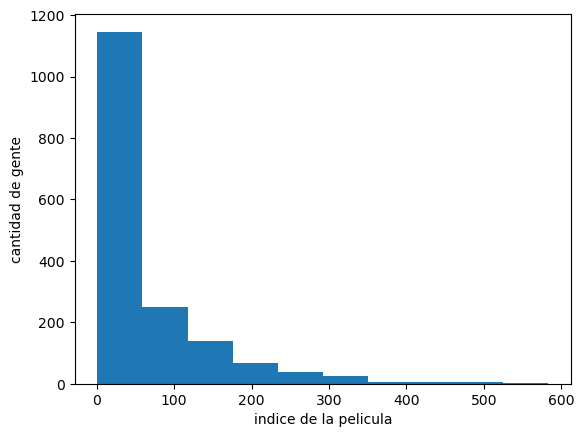

In [9]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())
plt.ylabel("cantidad de gente")
plt.xlabel("indice de la pelicula")

In [9]:
# para el sistema de recomendacion
# se necesita una matriz de valoraciones 
# de las peliculas
# [ cantidad de usuarios x cantidad de peliculas]



n_user = df.UserID.unique().shape[0]
n_items = df.ItemID.unique().shape[0]

ratings = np.zeros((n_user,n_items))



In [10]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Los ceros que se visualizan en la matriz se remplazaran segun las recomendaciones (prediccion)

In [11]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

se refiere a que hay un % disponible de los datos 

In [22]:
density = float(len(ratings.nonzero()[0]))
density /= (ratings.shape[0]*ratings.shape[1])
density*=100
print("coef de esparseidad: {:4.2f}%".format(density))

coef de esparseidad: 6.30%


In [13]:
ratings_train , ratings_test = train_test_split(ratings, test_size=0.3)

In [14]:
ratings_train.shape, ratings_test.shape

((660, 1682), (283, 1682))

se calculan las distancias coseno para calcular la similitud de los usuarios

In [18]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
sim_matrix.shape

(943, 943)

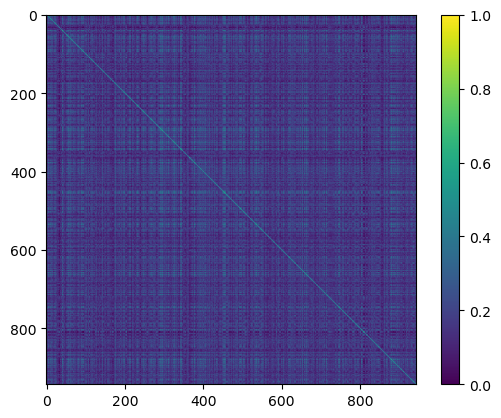

In [21]:
plt.imshow(sim_matrix)
plt.colorbar()
plt.show()

In [23]:
sim_matrix_train = sim_matrix[0:660,0:660]
sim_matrix_test = sim_matrix[660:943,660:943]
 
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

In [37]:
USUARIO_EJEMPLO = 3
data = df[df['UserID'] == USUARIO_EJEMPLO]
usuario_ver = data.iloc[0]['UserID'] - 1 # resta 1 para obtener el index de pandas.

In [41]:
user0=users_predictions.argsort()[usuario_ver]
 
# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
for i, aRepo in enumerate(user0[-3:]):
    selRepo = df[df['ItemID']==(aRepo+1)]
    print(selRepo['ItemID'] , 'puntaje:', users_predictions[usuario_ver][aRepo])

50       100
621      100
803      100
1114     100
1230     100
        ... 
99326    100
99510    100
99608    100
99822    100
99930    100
Name: ItemID, Length: 508, dtype: int64 puntaje: 2.1743656210077247
53       181
225      181
567      181
614      181
622      181
        ... 
98932    181
99653    181
99684    181
99745    181
99942    181
Name: ItemID, Length: 507, dtype: int64 puntaje: 2.184621822277418
499      50
857      50
1052     50
1090     50
1121     50
         ..
99567    50
99643    50
99853    50
99928    50
99948    50
Name: ItemID, Length: 583, dtype: int64 puntaje: 2.637811653811022


FILTRO BASADO EN LOS KNN.
En lugar de considerar todos los datos de los usuarios del dataset, lo normal es considerar el top K de usuarios mas parecidos o similares para que la informacion de la valoracion sea mas acertada basandonos en la similaridad y luego hacer la ponderacion para el top de usuarios 

Busca y compara los usuarios mas parecidos y los pondera para recomendar o no un determinado item de la base de dato


In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

In [18]:
def get_mse(preds, actuals):
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [19]:
neighbors = NearestNeighbors(n_neighbors=3, algorithm='brute')
neighbors.fit(ratings_train)

NearestNeighbors(algorithm='brute', n_neighbors=3)

In [20]:
top_k_distances , top_k_user = neighbors.kneighbors(ratings_train, return_distance=True)

In [21]:
top_k_distances.shape,top_k_user.shape

((660, 3), (660, 3))

In [22]:
top_k_distances[0] # me devuelve el top 10 de distancia entre cada usuario

array([ 0.        , 71.79136438, 71.90966555])

In [23]:
top_k_user[0]

array([  0, 400, 173], dtype=int64)

In [24]:
# el producto entre la distancia y los usuarios nos brinda una prediccion 
user_predict_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]): # para cada usuario del conjunto de train
    user_predict_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_user][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T


In [25]:
user_predict_k.shape

(660, 1682)

In [26]:
user_predict_k

array([[3.49958838, 1.50123487, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.50329685, 0.        , 2.48351577, ..., 0.        , 0.        ,
        0.        ],
       [3.49067265, 0.        , 1.50932735, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
get_mse(user_predict_k, ratings_train)

8.311159662702691

In [28]:
get_mse(user_predict_k, ratings_test)

11.661453967090836

BUSCAR SIMILARIDADES ENTRE PELICULAS 

In [29]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [32]:
neighbors = NearestNeighbors(n_neighbors=n_movies, algorithm='brute')

In [33]:
neighbors.fit(ratings_train.T)

NearestNeighbors(algorithm='brute', n_neighbors=1682)

In [34]:
top_k_distances_movies , top_k_user_movies = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [36]:
top_k_distances_movies.shape, top_k_user_movies.shape

((1682, 1682), (1682, 1682))

predecir valoracion de la pelicula

In [38]:
movies_preds = ratings_train.dot(top_k_distances_movies) / np.array([np.abs(top_k_distances_movies).sum(axis=1)])

In [40]:
movies_preds.shape

(660, 1682)

In [41]:
movies_preds

array([[0.        , 0.91362903, 1.03415631, ..., 4.77349808, 4.93949588,
        5.2169478 ],
       [0.        , 0.09909315, 0.11357278, ..., 0.33208703, 0.33769322,
        0.34584695],
       [0.        , 0.29103382, 0.32999245, ..., 1.20736911, 1.23984404,
        1.31381039],
       ...,
       [0.        , 0.23320893, 0.26521285, ..., 1.05640533, 1.0885109 ,
        1.14275353],
       [0.        , 0.06427334, 0.07368474, ..., 0.21504382, 0.21731883,
        0.22592865],
       [0.        , 0.07504564, 0.08659924, ..., 0.2613246 , 0.26490157,
        0.27179576]])

In [42]:
get_mse(movies_preds, ratings_train)

11.009171600612033

In [43]:
get_mse(movies_preds, ratings_test)

12.174818784973555

In [45]:
top_k_user_movies
# ej, la primera pelicula la compara con la 120 y la 116



array([[   0,  120,  116, ...,  312,  301,  285],
       [   1,  575,  577, ...,  285,   99,   49],
       [   2, 1323,   33, ...,  180,   99,   49],
       ...,
       [1493, 1432, 1121, ...,  180,   99,   49],
       [1493, 1432, 1121, ...,  180,   99,   49],
       [1681, 1679, 1121, ...,  180,   99,   49]], dtype=int64)

OTRA FORMA

In [8]:
import pandas as pd
from surprise import SVD
from surprise.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("u.data.csv",sep="\t",header=None)
df.columns = ["user_id","item_id","rating","timestamp"]

In [3]:
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [3]:
df.drop("timestamp", axis=1, inplace=True)

In [4]:
from surprise import Dataset, Reader
reader = Reader(rating_scale=(df["rating"].min(),df["rating"].max()))

In [5]:
dataset = Dataset.load_from_df(df,reader)

In [9]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.1, 0.01, 0.001], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['fcp',"rmse"], cv=5, refit=True)
gs.fit(dataset)
gs.best_score

In [13]:
best_model = gs.best_estimator["fcp"]

In [15]:
pred = best_model.predict("196", "242")
pred

Prediction(uid='196', iid='242', r_ui=None, est=3.52986, details={'was_impossible': False})

In [16]:
df

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [9]:
from surprise import SVDpp
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.1, 0.01, 0.001], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVDpp, param_grid, measures=['fcp',"rmse"], cv=5, refit=True)
gs.fit(dataset)
gs.best_score

{'fcp': 0.6943009193272643, 'rmse': 0.9571911320460741}

In [10]:
best_model = gs.best_estimator["fcp"]
pred = best_model.predict("196", "242")
pred

Prediction(uid='196', iid='242', r_ui=None, est=3.52986, details={'was_impossible': False})